In [182]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from functools import reduce  
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


In [2]:
p = 7
n = 1000
min_cor = 0
max_cor = 0

true_betas = np.array(np.repeat(5, p))
true_betas

array([5, 5, 5, 5, 5, 5, 5])

In [3]:
def get_sim_data(p, n, min_cor, max_cor, true_betas):
    
    sd_vec = np.ones(p) 
    mean = np.zeros(p)
    cor_matrix = np.zeros((p,p))

    correlation = np.random.uniform(min_cor, max_cor, int(p * (p - 1) / 2))
    cor_matrix[np.triu_indices(p, 1)] = correlation
    cor_matrix[np.tril_indices(p, -1)] = cor_matrix.T[np.tril_indices(p, -1)]
    np.fill_diagonal(cor_matrix, 1)


    D = np.diag(sd_vec)
    sigma = D.dot(cor_matrix).dot(D)

    X = np.random.multivariate_normal(mean, sigma, n)
    eps = np.random.normal(0, 1, n)
    
    y_true = X.dot(true_betas)
    y_true = pd.Series(y_true, name = 'y_true')

    y_noise = y_true + eps 
    y_noise = pd.Series(y_noise, name = 'y_noise')
    
    column_names = []
    
    for value in range(1, p + 1): 
        
        column = f"X_{value}"
        column_names.append(column)
        
    
    X = pd.DataFrame(X, columns = column_names)
    
    df = pd.concat([y_noise, X], axis = 1)
    
    return y_true, y_noise, X, df



In [4]:
y_true, y_noise, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas)


In [9]:
"""Zero multicollinearity.
   n = 30; p = 2, 28, 30, 35. 
"""
np.random.seed(123)

n_sim = 30
p_sim = np.array([2, 28, 30, 35])

min_corr_sim = 0
max_corr_sim = 0 
iterations_sim = 1000

matrix_betas_final = []
matrix_betas_mean = []
matrix_bias_sq = []
matrix_betas_var_mean = []
matrix_betas_var_final = []


    
for p in p_sim: 
    
    matrix_var = []
    matrix_betas = []
    
    for i in range(iterations_sim):
    
        true_betas_sim = np.repeat(5, p)
    
        y_true, y_noise, X, df = get_sim_data(p, n_sim, min_corr_sim, max_corr_sim, true_betas_sim) 

        var_cov = np.linalg.inv(np.dot(X.T, X))
        var_betas = var_cov.diagonal() 
        
        #reg = LinearRegression().fit(X, y)
        betas = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_noise)
        
        #matrix_betas.append(reg.coef_)
        matrix_betas.append(betas)
        
        matrix_var.append(var_betas)
        
        X_names = []
        beta_names = []
    
        for value in range(1, p + 1): 
            
            column_X = f"X_{value}"
            column_betas = f"beta_{value}"
            X_names.append(column_X)
            beta_names.append(column_betas)
        
        df_var = pd.DataFrame(matrix_var, columns = X_names)
        df_betas = pd.DataFrame(matrix_betas, columns = beta_names) 
        
        #bias_squared = (df_betas.mean() - true_betas_sim)**2
        
    matrix_betas_final.append(df_betas)
    matrix_betas_mean.append(df_betas.mean())
    #matrix_bias_sq.append(bias_squared)
    matrix_betas_var_mean.append(df_var.mean())
    matrix_betas_var_final.append(df_var)
    
 

In [176]:
#matrix_betas_var_mean[1]
#matrix_betas_mean[0]
#matrix_betas_var_mean[2]
#matrix_betas_var_mean[3]
#matrix_betas_var_mean[4]
#matrix_betas_var_mean[5]
#matrix_betas_var_final
#len(matrix_betas_final)
matrix_betas_final


[       beta_1    beta_2
 0    5.194390  4.814442
 1    4.955953  5.106284
 2    4.915828  4.819898
 3    4.958054  4.814023
 4    5.196928  5.342399
 ..        ...       ...
 995  5.344032  4.789137
 996  5.120733  5.102066
 997  5.031395  4.879691
 998  5.136747  5.185013
 999  4.822832  4.781346
 
 [1000 rows x 2 columns],
        beta_1    beta_2    beta_3    beta_4    beta_5    beta_6    beta_7  \
 0    4.625958  5.709232  5.578969  6.786126  3.711638  5.771189  4.150237   
 1    6.275114  6.594062  4.458962  4.185813  5.622896  5.061225  6.401124   
 2    4.346290  4.313042  3.491141  4.206173  5.769389  5.280490  5.344267   
 3    5.079610  5.361217  4.746899  5.221811  5.298139  5.713871  5.014280   
 4    5.278163  5.168689  4.397753  5.175896  4.277409  5.030779  5.594457   
 ..        ...       ...       ...       ...       ...       ...       ...   
 995  5.161355  4.563418  4.251050  4.384264  4.870468  5.038473  5.309125   
 996  4.861911  3.079180  4.699782  4.351605  7.

In [180]:
#list(enumerate(matrix_betas_final))
matrix_betas_final[0]

,beta_1,beta_2
0,5.194390,4.814442
1,4.955953,5.106284
2,4.915828,4.819898
3,4.958054,4.814023
4,5.196928,5.342399
...,...,...
995,5.344032,4.789137
996,5.120733,5.102066
997,5.031395,4.879691
998,5.136747,5.185013


In [13]:
def iterate_ridge(n, p, min_cor, max_cor, iterations_sim, true_betas, alphas):
    
    beta_var_names = []
    ridge_beta_names = []
    
    for value in range(1, p + 1): 
    
        column_betas_var = f"beta_var_{value}"
        column_betas = f"beta_{value}"
        beta_var_names.append(column_betas_var)
        ridge_beta_names.append(column_betas)

    df_list_betas_ridge = []
    df_list_var_ridge = []

    for i in range(iterations_sim):
        
        true_betas_sim = true_betas
    
        y_true, y_noise, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas_sim) 
        
        i, k = X.shape
        I = np.identity(k)
    
        matr_var = []
        matr_beta = []
    

        for a in alphas: 
        
            ridge_beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), X.T), y_noise)
            matr_beta.append(ridge_beta)
            df_ridge_betas = pd.DataFrame(matr_beta, columns = ridge_beta_names)
        
            ridge_var_cov = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), np.dot(X.T, X)), np.linalg.inv(np.dot(X.T, X) + a * I))
            ridge_var = ridge_var_cov.diagonal()
            matr_var.append(ridge_var)
            df_ridge_var = pd.DataFrame(matr_var, columns = beta_var_names)
        
         
        df_list_betas_ridge.append(df_ridge_betas)
        df_list_var_ridge.append(df_ridge_var)
        
    return df_list_betas_ridge, df_list_var_ridge



In [328]:
n_alphas = 30
alphas_1 = np.logspace(-5, 4, n_alphas)
alphas_1

alphas_2 = np.logspace(-15, -12, 5)
alphas_2

array([1.00000000e-15, 5.62341325e-15, 3.16227766e-14, 1.77827941e-13,
       1.00000000e-12])

In [157]:
np.random.seed(20)

p_regressors = [2, 28, 30, 35]
n = 30
#true_betas = np.repeat(5, p)
min_cor = 0 
max_cor = 0 
iterations = 1

#alphas_1 = np.array([int(0), 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 15, 20, 30, 50, 100, 120, 150, 160, 200, 210, 300, 500, 1000, 10000])
#alphas_2 = np.array([int(0), 0.000000000000001, 0.00000000000001, 0.0000000000001, 0.000000000001])

alphas = [alphas_1, alphas_1, alphas_1, alphas_2]


collect_ridge_betas = []
collect_ridge_var = []

for p, a in zip(p_regressors, alphas): 
    
    ridge_betas, beta_var = iterate_ridge(n, p, min_cor, max_cor, iterations, np.repeat(5, p), a)
    collect_ridge_betas.append(ridge_betas)
    collect_ridge_var.append(beta_var)
    
    


In [230]:
#len(collect_ridge_betas)

list(enumerate(collect_ridge_betas))

#regularization_type = "Ridge"

collect_ridge_betas[0][0]

[(0,
  [      beta_1    beta_2
   0   4.881688  4.804227
   1   4.881687  4.804226
   2   4.881685  4.804223
   3   4.881680  4.804217
   4   4.881671  4.804204
   5   4.881652  4.804178
   6   4.881613  4.804126
   7   4.881535  4.804019
   8   4.881374  4.803799
   9   4.881046  4.803352
   10  4.880376  4.802437
   11  4.879007  4.800570
   12  4.876211  4.796758
   13  4.870509  4.788988
   14  4.858900  4.773189
   15  4.835353  4.741225
   16  4.787951  4.677214
   17  4.693966  4.551602
   18  4.513098  4.314671
   19  4.184143  3.899410
   20  3.642775  3.257543
   21  2.882632  2.436060
   22  2.022293  1.606213
   23  1.256862  0.946272
   24  0.708920  0.514171
   25  0.374965  0.265937
   26  0.191063  0.133864
   27  0.095429  0.066439
   28  0.047177  0.032741
   29  0.023204  0.016078]),
 (1,
  [      beta_1    beta_2    beta_3    beta_4    beta_5    beta_6    beta_7  \
   0   5.562476  5.790830  5.988280  4.194307  6.193958  5.833829  5.239480   
   1   5.562369  5.7906

In [174]:
def plot_betas(dfs, alphas, reg_type):

    plt.figure(figsize = (40,25))

    for i, a in zip(enumerate(dfs), alphas):
        plt.subplot(2, 2, i[0] + 1)
    
        ax = plt.gca()
    
        ax.plot(a, i[1][0])
    
        ax.set_xscale("log")
        ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    
        plt.xlabel("alpha", fontsize = 25)
        plt.ylabel("weights", fontsize = 25)
    
        ax.tick_params(axis='both', which='major', labelsize = 20)

        plt.title(f"{reg_type} coefficients as a function of $\lambda$, p = {i[1][0].shape[1]} ", fontsize = 28)
        plt.axis("tight")
        #plt.show()
    
    

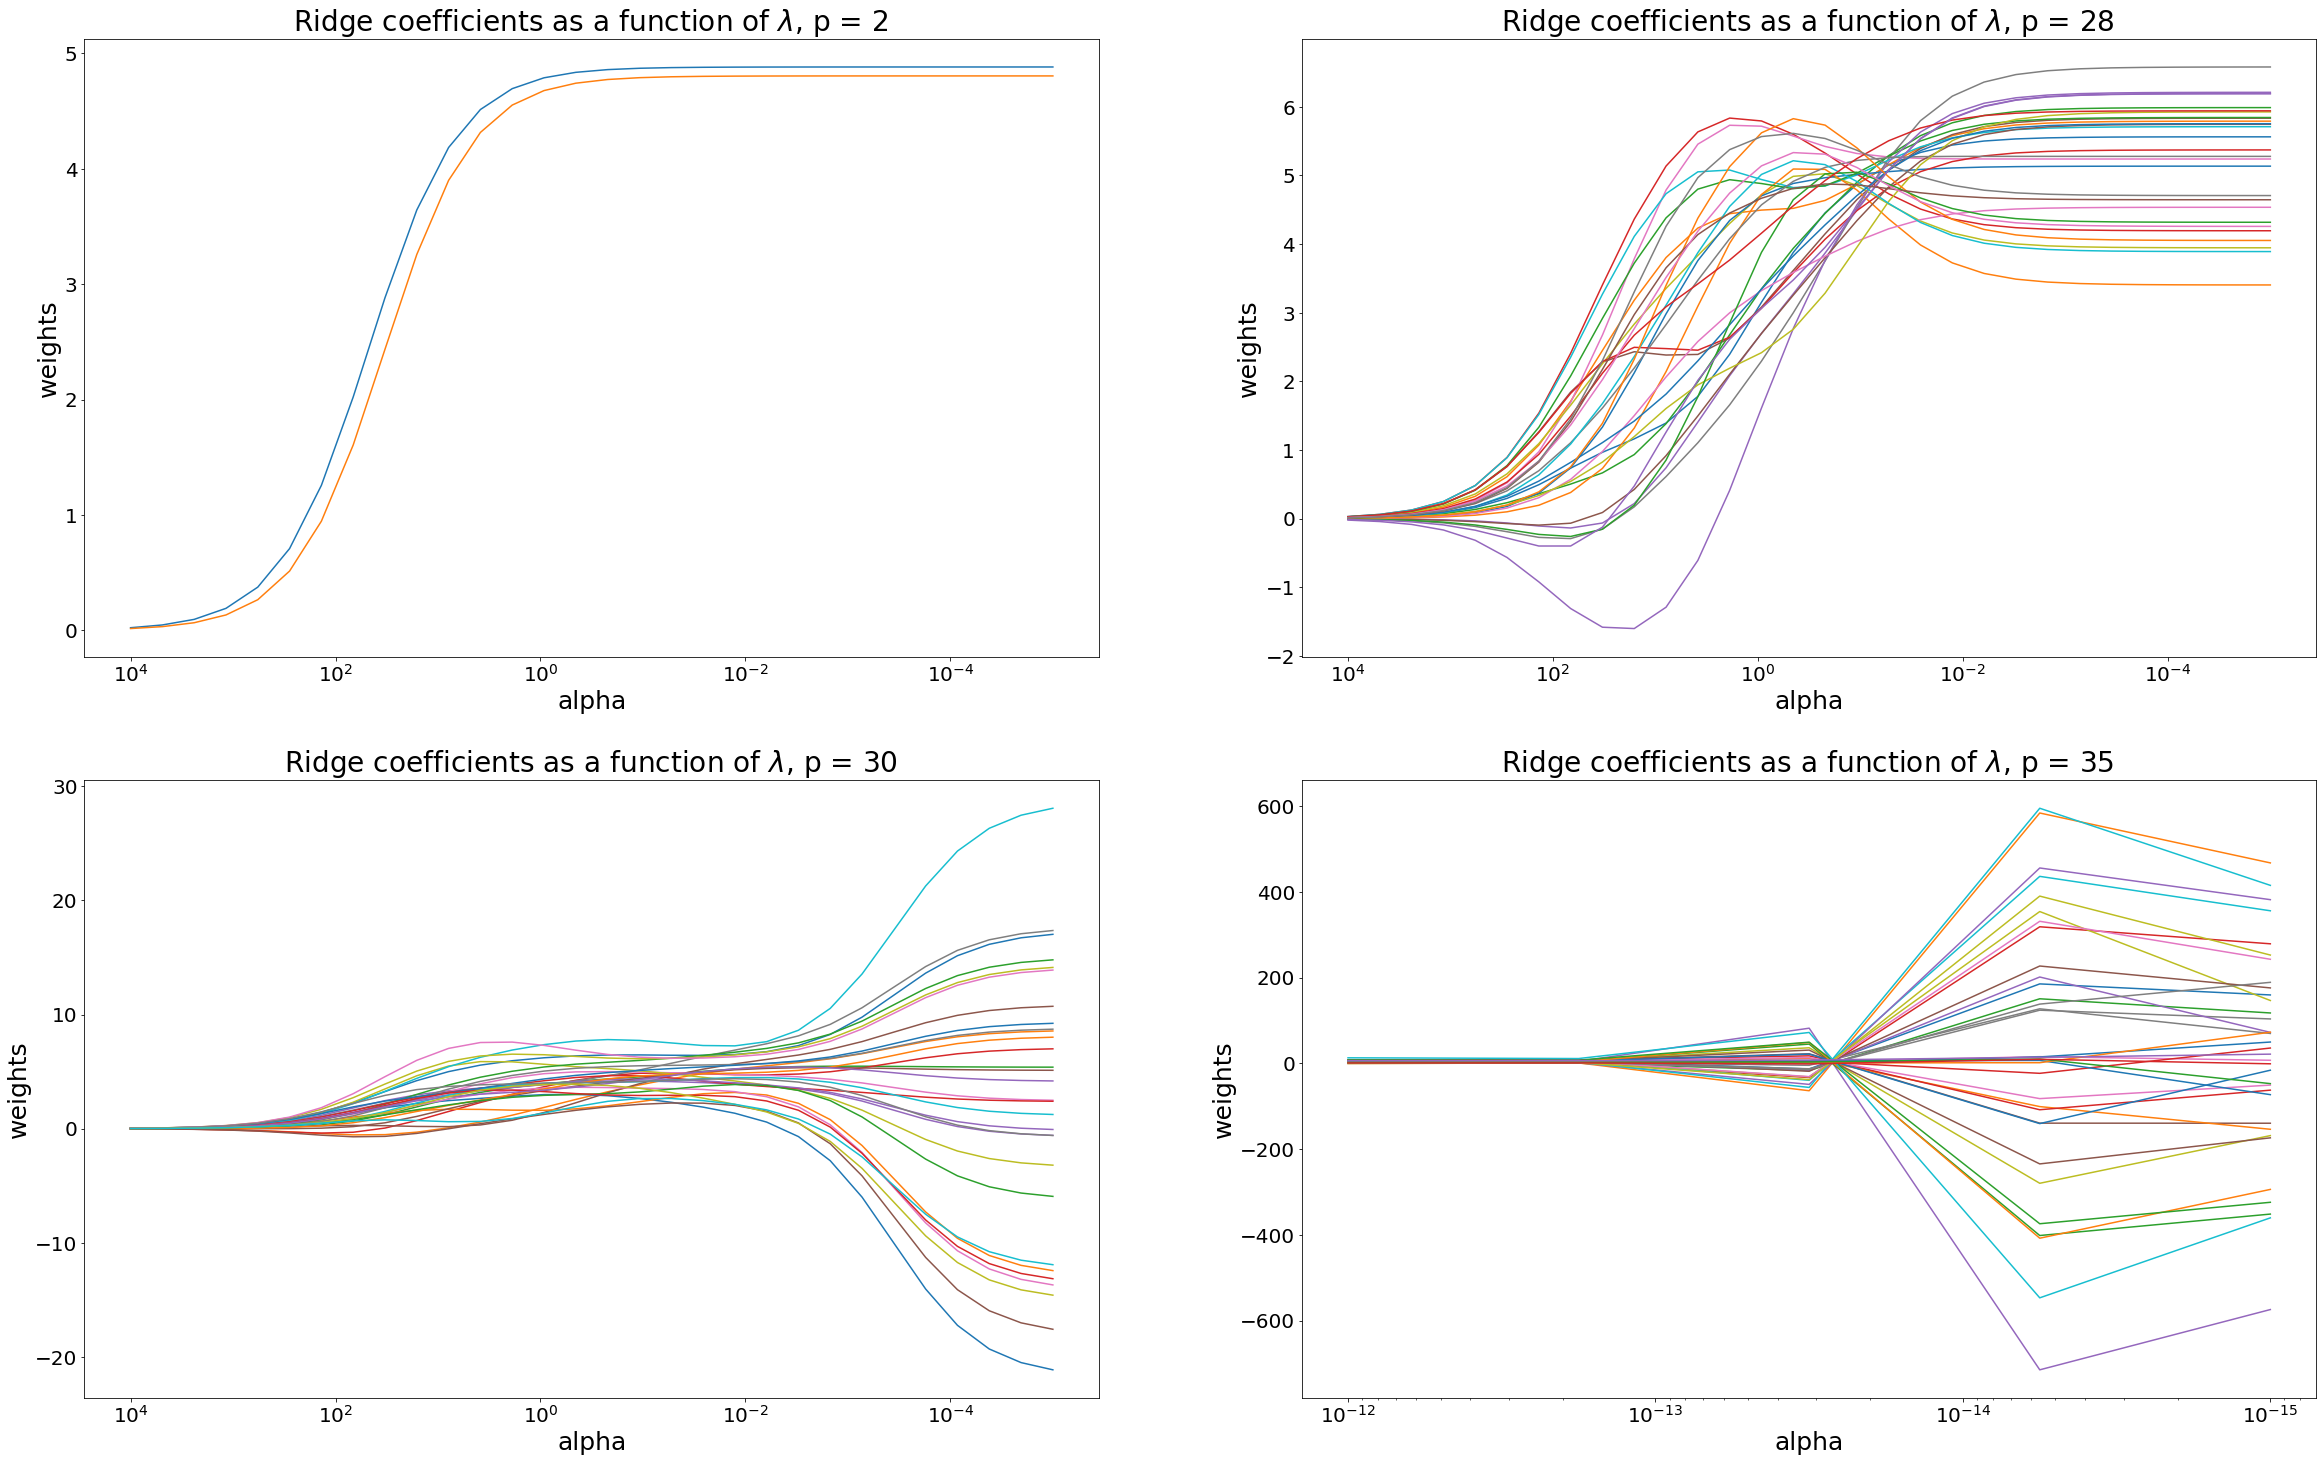

In [175]:
plot_betas(collect_ridge_betas, alphas, regularization_type)

$$
V\left(\hat{\boldsymbol{\beta}}^{*}\right)=\sigma^{2}\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}\left(\mathbf{X}^{\prime} \mathbf{X}\right)\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}.
$$

In [314]:
n = 30
min_cor = 0 
max_cor = 0 
iterations_sim = 1000

#alphas = np.array([0, 0.000000000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 15, 20]) 


In [338]:
np.random.seed(15)

df_list_betas_ridge_2, df_list_var_ridge_2 = iterate_ridge(n, 2, min_cor, max_cor, iterations_sim, np.repeat(5, 2), alphas_1)

mean_df_list_betas_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_2) / iterations_sim
mean_df_list_var_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_2) / iterations_sim

#mean_df_list_betas_ridge_2
#mean_df_list_betas_ridge_2["alpha"] = alphas_1
#mean_df_list_betas_ridge_2.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_2

#mean_df_list_var_ridge_2
#mean_df_list_var_ridge_2["alpha"] = alphas_1
#mean_df_list_var_ridge_2.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_2
    


In [339]:
df_list_betas_ridge_28, df_list_var_ridge_28 = iterate_ridge(n, 28, min_cor, max_cor, iterations_sim, np.repeat(5, 28), alphas_1)

mean_df_list_betas_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_28) / iterations_sim
mean_df_list_var_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_28) / iterations_sim

#mean_df_list_betas_ridge_28
#mean_df_list_betas_ridge_28["alpha"] = alphas_1
#mean_df_list_betas_ridge_28.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_28
    
#mean_df_list_var_ridge_28
#mean_df_list_var_ridge_28["alpha"] = alphas_1
#mean_df_list_var_ridge_28.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_28

In [340]:
df_list_betas_ridge_30, df_list_var_ridge_30 = iterate_ridge(n, 30, min_cor, max_cor, iterations_sim, np.repeat(5, 30), alphas_1)

mean_df_list_betas_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_30) / iterations_sim
mean_df_list_var_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_30) / iterations_sim

#mean_df_list_betas_ridge_30
#mean_df_list_betas_ridge_30["alpha"] = alphas_1
#mean_df_list_betas_ridge_30.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_30
    
#mean_df_list_var_ridge_30
#mean_df_list_var_ridge_30["alpha"] = alphas_1
#mean_df_list_var_ridge_30.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_30

In [341]:
#alphas = np.array([0, 0.00000000000000000001, 0.00000000000001, 0.000000000001]) 


df_list_betas_ridge_35, df_list_var_ridge_35 = iterate_ridge(n, 35, min_cor, max_cor, iterations_sim, np.repeat(5, 35), alphas_2)

mean_df_list_betas_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_35) / iterations_sim
mean_df_list_var_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_35) / iterations_sim

#mean_df_list_betas_ridge_35
#mean_df_list_betas_ridge_35["alpha"] = alphas_2
#mean_df_list_betas_ridge_35.set_index("alpha", inplace = True)
#mean_df_list_betas_ridge_35
    
#mean_df_list_var_ridge_35
#mean_df_list_var_ridge_35["alpha"] = alphas_2
#mean_df_list_var_ridge_35.set_index("alpha", inplace = True)
#mean_df_list_var_ridge_35

In [342]:
dfs_try = [mean_df_list_betas_ridge_2, mean_df_list_betas_ridge_28, mean_df_list_betas_ridge_30, mean_df_list_betas_ridge_35]
#alphas_1 = np.array([0, 0.000000000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 15, 20]) 

#alphas_2 = np.array([0, 0.00000000000000000001, 0.00000000000001, 0.000000000001]) 

#alphas = [alphas_1, alphas_1, alphas_1, alphas_2]


#list(enumerate(dfs))

In [343]:
def plot_average_betas(dfs, alphas, reg_type):

    plt.figure(figsize = (40, 25))
    count = 1

    for i, a in zip(dfs, alphas):
        plt.subplot(2, 2, count)
    
        ax = plt.gca()
    
        ax.plot(a, i)
    
        ax.set_xscale("log")
        ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    
        plt.xlabel("alpha", fontsize = 25)
        plt.ylabel("weights", fontsize = 25)
    
        ax.tick_params(axis='both', which='major', labelsize = 20)
        ax.set_ylim([0, 6])

        plt.title(f"{reg_type} coefficients as a function of $\lambda$, p = {i.shape[1]} ", fontsize = 28)
        plt.axis("tight")
        count += 1
        #plt.show()

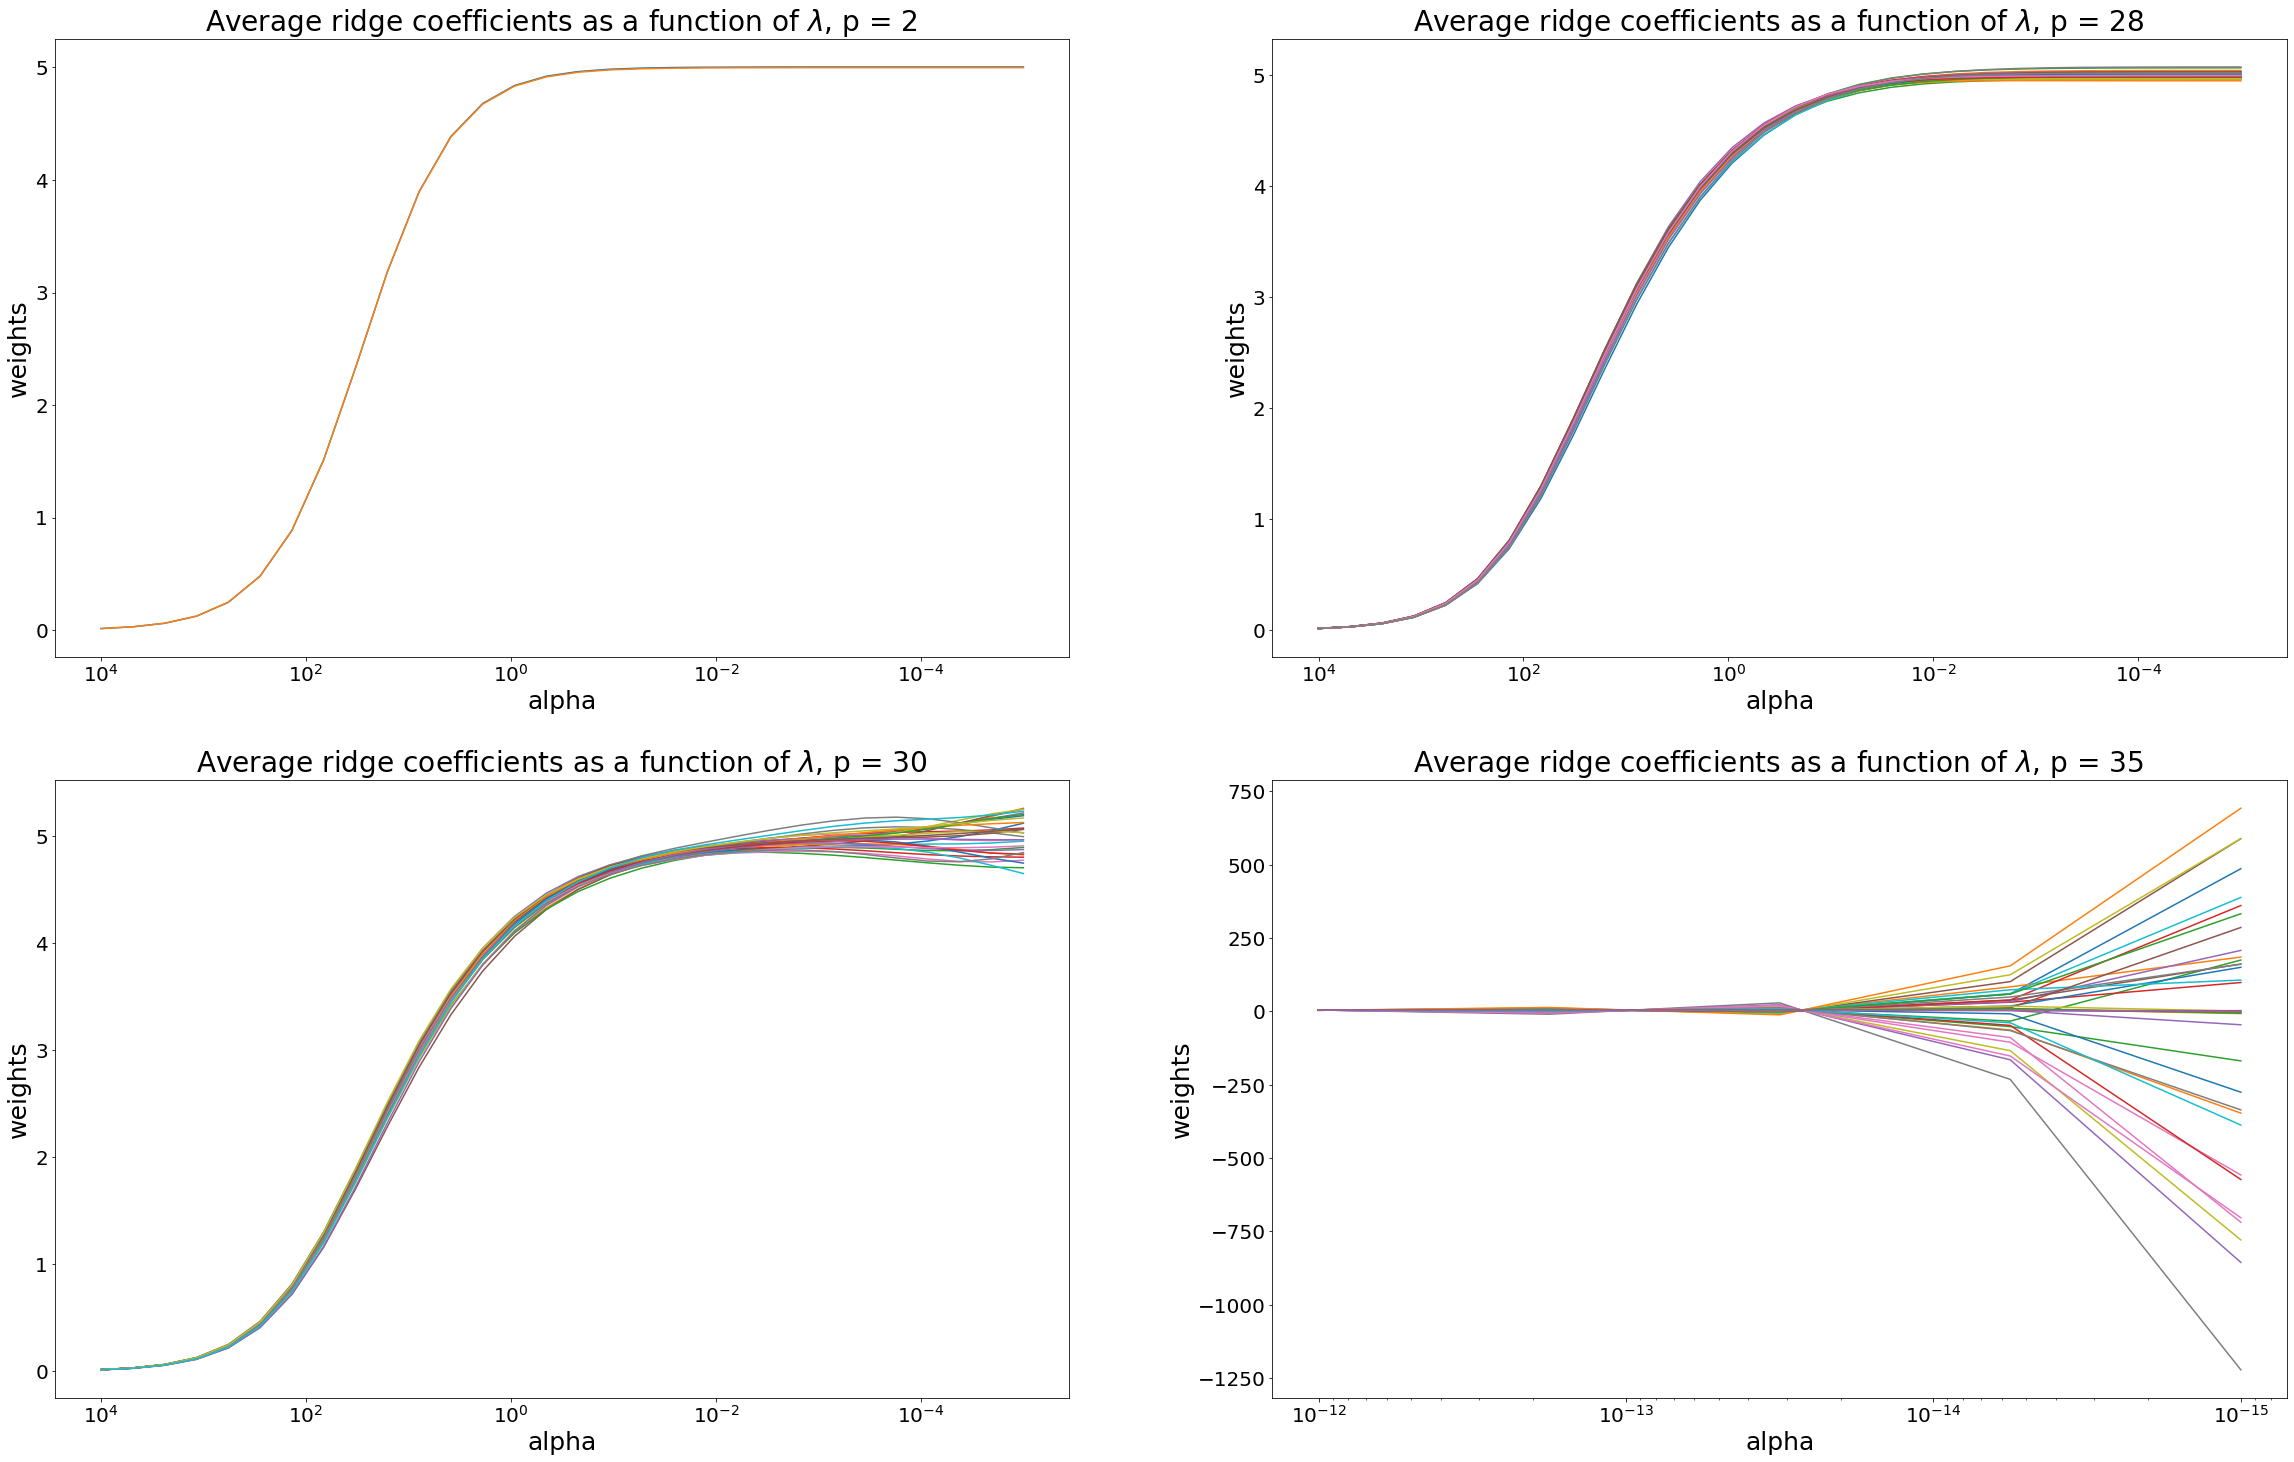

In [344]:
reg_type = "Average ridge"
alphas = [alphas_1, alphas_1, alphas_1, alphas_2]

plot_average_betas(dfs_try, alphas, reg_type)

## MSE Work 

In [338]:
n = 30
p = 35 
min_cor = 0 
max_cor = 0 
true_betas = np.repeat(5, p)

y_true_train, y_noise_train, X_train, df_train = get_sim_data(p, n, min_cor, max_cor, true_betas)
y_true_test, y_noise_test, X_test, df_test = get_sim_data(p, n, min_cor, max_cor, true_betas)



In [123]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn import metrics

In [345]:
alphas = np.array([0, 0.00000000000000000001, 0.0000000000000000001, 0.000000000000000001, 0.00000000000000001, 0.000000000000001, 0.000000000001, 0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5, 1, 2]) 

save_mse = []
save_mse_sci = []
save_var = []
save_var_trial = []
save_bias = []

for a in alphas: 
    ridge = Ridge(alpha=a).fit(X_train, y_true_train)
    ridge_predict = ridge.predict(X_test)

    squared_dist = (ridge_predict - y_true_test)**2
    MSE = np.mean(squared_dist)
    save_mse.append(MSE)
    
    MSE_sci = metrics.mean_squared_error(ridge_predict, y_true_test)
    save_mse_sci.append(MSE_sci)
    
    var_predicted_y = np.mean((np.mean(ridge_predict) - ridge_predict)**2)
    var_predicted_y_trial = np.sum((ridge_predict - np.mean(ridge_predict))**2) / 30


    save_var.append(var_predicted_y)
    save_var_trial.append(var_predicted_y_trial)
    
    bias_squared = np.mean((ridge_predict.mean() - y_noise_test)**2)
    save_bias.append(bias_squared)



/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving du

In [346]:
save_mse

[200.1516260068284,
 200.1516260068284,
 200.1516260068284,
 200.1516260068284,
 200.1516260068284,
 200.15162600682834,
 200.15162600678508,
 200.15162556783983,
 200.15118702795476,
 200.14723712278177,
 200.10782741950686,
 199.7224541910988,
 196.57082533603852,
 194.08050822189932,
 193.09237215806863,
 192.23007268636923,
 191.47131825228018,
 189.67070579196513,
 186.79266446409258,
 188.11412013541204]

In [347]:
save_mse_sci

[200.1516260068284,
 200.1516260068284,
 200.1516260068284,
 200.1516260068284,
 200.1516260068284,
 200.15162600682837,
 200.15162600678505,
 200.15162556783983,
 200.15118702795476,
 200.14723712278177,
 200.1078274195068,
 199.72245419109876,
 196.57082533603852,
 194.08050822189932,
 193.09237215806868,
 192.23007268636925,
 191.47131825228016,
 189.67070579196516,
 186.79266446409264,
 188.11412013541198]

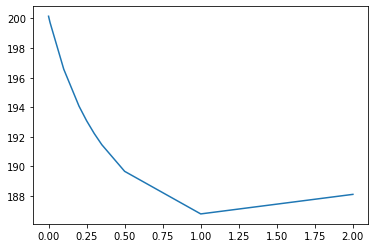

In [348]:
plt.plot(alphas, save_mse)
#plt.plot(np.log(alphas), save_var)

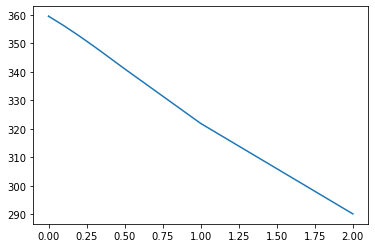

In [349]:
plt.plot(alphas, save_var_trial)

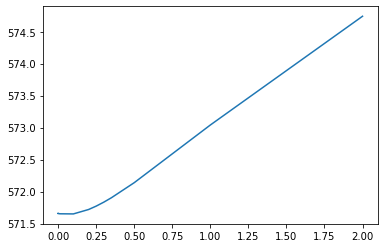

In [350]:
plt.plot(alphas, save_bias)